In [1]:
%load_ext autoreload
%autoreload 2

In [179]:
import os

import numpy as np
import pandas as pd

import gymnasium

from tf_agents.trajectories.time_step import TimeStep

from dice_rl_plugins.environment import test_env
from dice_rl_plugins.value import get_get_policy_value_dataset
from dice_rl_plugins.estimators.tabular.test import test_estimator, test_aux_estimates
from dice_rl_plugins.plot.tabular import plot_pvs
from dice_rl_plugins.estimators.get import (
    get_gammas_1, get_gammas_2,
    get_pv_s_OnPE, get_pv_s_OffPE, )

from dice_rl_plugins.estimators.tabular.aux_estimates.io import load_or_create_aux_estimates
from dice_rl_plugins.estimators.tabular.tabular_vafe          import TabularVafe
from dice_rl_plugins.estimators.tabular.tabular_dice          import TabularDice
from dice_rl_plugins.estimators.tabular.tabular_dual_dice     import TabularDualDice
from dice_rl_plugins.estimators.tabular.tabular_gradient_dice import TabularGradientDice

from dice_rl_plugins.applications.gymnasium.taxi.config import *
from dice_rl_plugins.applications.gymnasium.scripts.run_tabular_dual_dice import run_tabular_dual_dice

from utils.general import unpack
from utils.bedtime import computer_sleep

In [3]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_column", 100)

# Values

In [4]:
get_policy_value = {}
rewards = {}

for k in K:
    x, y = get_get_policy_value_dataset(dataset=dataset[k], by="episodes")

    get_policy_value[k] = x
    rewards[k] = y

100%|██████████| 101/101 [00:01<00:00, 87.58it/s]


In [5]:
for k in K:
    get_policy_value[k].__name__ = f"OnPE {names[k]}"

# Estimators

In [30]:
aux_estimates = {
    k: load_or_create_aux_estimates(
        aux_estimates_dir=aux_estimates_dir[k],
        dataset=dataset[k],
        target_policy=target_policy,
        by="episodes",
    )
        for k in K
}

loaded data/dice_rl/taxi/outputs/taxi_tabularTrue_alpha0.0_seed0_numtraj1000_maxtraj100/by=episodes_obs_act=True/d0_bar.npy
loaded data/dice_rl/taxi/outputs/taxi_tabularTrue_alpha0.0_seed0_numtraj1000_maxtraj100/by=episodes_obs_act=True/dD_bar.npy
loaded data/dice_rl/taxi/outputs/taxi_tabularTrue_alpha0.0_seed0_numtraj1000_maxtraj100/by=episodes_obs_act=True/P_bar.npy
loaded data/dice_rl/taxi/outputs/taxi_tabularTrue_alpha0.0_seed0_numtraj1000_maxtraj100/by=episodes_obs_act=True/r_bar.npy
loaded data/dice_rl/taxi/outputs/taxi_tabularTrue_alpha0.0_seed0_numtraj1000_maxtraj100/by=episodes_obs_act=True/n.npy
loaded data/dice_rl/taxi/outputs/taxi_tabularTrue_alpha1.0_seed0_numtraj1000_maxtraj100/by=episodes_obs_act=True/d0_bar.npy
loaded data/dice_rl/taxi/outputs/taxi_tabularTrue_alpha1.0_seed0_numtraj1000_maxtraj100/by=episodes_obs_act=True/dD_bar.npy
loaded data/dice_rl/taxi/outputs/taxi_tabularTrue_alpha1.0_seed0_numtraj1000_maxtraj100/by=episodes_obs_act=True/P_bar.npy
loaded data/dice

In [33]:
estimators_OnPE = get_policy_value

estimators_VAFE = {
    k: [ TabularVafe(aux_estimates=aux_estimates[k], num_obs=2_000, n_act=6), ]
        for k in K
}

estimators_DICE = {}

for k in K:
    args = [ dataset[k], target_policy, aux_estimates[k], ]
    estimators_DICE[k] = [ TabularDice(*args), TabularDualDice(*args), TabularGradientDice(*args), ]

estimators_OffPE = {
    k: estimators_VAFE[k] + estimators_DICE[k]
        for k in K
}

# `get_pvs`

In [165]:
gammas_1 = get_gammas_1()
gammas_2 = get_gammas_2()

projected = True
modified = True
lam = 1e-6

In [45]:
# pvs_OnPE

pvs_OnPE_1 = {
    k: get_pv_s_OnPE(
        estimator_s=estimators_OnPE[k],
        gamma_s=gammas_1,
    )
        for k in K
}

pvs_OnPE_2 = {
    k: get_pv_s_OnPE(
        estimator_s=estimators_OnPE[k],
        gamma_s=gammas_2,
    )
        for k in K
}

OnPE behavior


100%|██████████| 9/9 [00:00<00:00, 1231.20it/s]


OnPE evaluation


100%|██████████| 9/9 [00:00<00:00, 6319.90it/s]


OnPE behavior


100%|██████████| 17/17 [00:00<00:00, 5937.97it/s]


OnPE evaluation


100%|██████████| 17/17 [00:00<00:00, 3004.01it/s]


In [46]:
# pvs_OffPE

pvs_VAFE_1 = {
    k: get_pv_s_OffPE(
        estimator_s=estimators_VAFE[k],
        gamma_s=gammas_1,
        projected=projected, weighted=None,
        modified=modified, lam=lam,
    )
        for k in K
}

pvs_VAFE_2 = {
    k: get_pv_s_OffPE(
        estimator_s=estimators_VAFE[k],
        gamma_s=gammas_2,
        projected=projected, weighted=None,
        modified=modified, lam=lam,
    )
        for k in K
}

print("\n", "#", "-"*64, "#", "\n")

pvs_DICE_s_1 = {
    k: get_pv_s_OffPE(
        estimators_DICE[k],
        gammas_1,
        projected=projected, weighted=False,
        modified=modified, lam=lam,
    )
        for k in K
}

pvs_DICE_s_2 = {
    k: get_pv_s_OffPE(
        estimators_DICE[k],
        gammas_2,
        projected=projected, weighted=False,
        modified=modified, lam=lam,
    )
        for k in K
}

print("\n", "#", "-"*64, "#", "\n")

pvs_DICE_w_1 = {
    k: get_pv_s_OffPE(
        estimators_DICE[k],
        gammas_1,
        projected=projected, weighted=True,
        modified=modified, lam=lam,
    )
        for k in K
}

pvs_DICE_w_2 = {
    k: get_pv_s_OffPE(
        estimators_DICE[k],
        gammas_2,
        projected=projected, weighted=True,
        modified=modified, lam=lam,
    )
        for k in K
}

print("\n", "#", "-"*64, "#", "\n")

pvs_DICE_1 = { False: pvs_DICE_s_1, True: pvs_DICE_w_1, }
pvs_DICE_2 = { False: pvs_DICE_s_2, True: pvs_DICE_w_2, }

TabularVafe


100%|██████████| 9/9 [01:49<00:00, 12.18s/it]


TabularVafe


100%|██████████| 9/9 [01:40<00:00, 11.21s/it]


TabularVafe


100%|██████████| 17/17 [03:21<00:00, 11.87s/it]


TabularVafe


100%|██████████| 17/17 [03:03<00:00, 10.77s/it]



 # ---------------------------------------------------------------- # 

TabularDice


100%|██████████| 9/9 [00:37<00:00,  4.12s/it]


TabularDualDice


100%|██████████| 9/9 [06:10<00:00, 41.15s/it]


TabularGradientDice


/Users/richardweiss/Library/CloudStorage/OneDrive-Persönlich/Masterarbeit/dice_rl_TU_Vienna/dice_rl_plugins/estimators/tabular/tabular_dice.py:38: UserWarning: negative sdc value encountered
  warnings.warn("negative sdc value encountered", UserWarning)
100%|██████████| 9/9 [06:49<00:00, 45.48s/it]


TabularDice


100%|██████████| 9/9 [00:32<00:00,  3.67s/it]


TabularDualDice


100%|██████████| 9/9 [05:30<00:00, 36.70s/it]


TabularGradientDice


100%|██████████| 9/9 [05:57<00:00, 39.72s/it]


TabularDice


100%|██████████| 17/17 [01:06<00:00,  3.92s/it]


TabularDualDice


100%|██████████| 17/17 [12:00<00:00, 42.35s/it]


TabularGradientDice


100%|██████████| 17/17 [14:04<00:00, 49.67s/it]


TabularDice


100%|██████████| 17/17 [01:13<00:00,  4.32s/it]


TabularDualDice


100%|██████████| 17/17 [12:10<00:00, 42.99s/it]


TabularGradientDice


100%|██████████| 17/17 [12:28<00:00, 44.01s/it]



 # ---------------------------------------------------------------- # 

TabularDice


100%|██████████| 9/9 [00:40<00:00,  4.52s/it]


TabularDualDice


100%|██████████| 9/9 [07:30<00:00, 50.02s/it]


TabularGradientDice


100%|██████████| 9/9 [07:15<00:00, 48.35s/it]


TabularDice


100%|██████████| 9/9 [00:25<00:00,  2.79s/it]


TabularDualDice


100%|██████████| 9/9 [05:05<00:00, 33.90s/it]


TabularGradientDice


100%|██████████| 9/9 [05:37<00:00, 37.54s/it]


TabularDice


100%|██████████| 17/17 [02:01<00:00,  7.12s/it]


TabularDualDice


100%|██████████| 17/17 [3:22:27<00:00, 714.57s/it]


TabularGradientDice


100%|██████████| 17/17 [22:53<00:00, 80.77s/it]


TabularDice


100%|██████████| 17/17 [00:43<00:00,  2.59s/it]


TabularDualDice


100%|██████████| 17/17 [10:20<00:00, 36.51s/it]


TabularGradientDice


100%|██████████| 17/17 [10:15<00:00, 36.21s/it]


In [48]:
# pv_OnPE

pv_OnPE = { k: rewards[k].mean(axis=1).mean() for k in K }

In [49]:
# pv_DICE, sdc_DICE

pv_DICE_s = {}
pv_DICE_w = {}

for k in K:

    pv_DICE_s[k], *_ = estimators_DICE[k][0].solve(
        gamma=1, projected=projected, weighted=False, modified=modified, )

    pv_DICE_w[k], *_ = estimators_DICE[k][0].solve(
        gamma=1, projected=projected, weighted=True, modified=modified, )

pv_DICE = { False: pv_DICE_w, True: pv_DICE_w, }

In [50]:
# pvs_VAFE_1 = { k: [[0] * len(gammas_1)] for k in K }
# pvs_VAFE_2 = { k: [[0] * len(gammas_2)] for k in K }

# pvs_DICE_s_1 = { k: [ [0] * len(gammas_1) ] * len(estimators_DICE[k]) for k in K}
# pvs_DICE_s_2 = { k: [ [0] * len(gammas_2) ] * len(estimators_DICE[k]) for k in K}

# pvs_DICE_w_1 = { k: [ [0] * len(gammas_1) ] * len(estimators_DICE[k]) for k in K}
# pvs_DICE_w_2 = { k: [ [0] * len(gammas_2) ] * len(estimators_DICE[k]) for k in K}

# pv_DICE_s = { k: 0 for k in K }
# pv_DICE_w = { k: 0 for k in K }

# Plot

In [163]:
env_title = "Taxi"

colors_OnPE = ["lightgrey", "grey"]
colors_VAFE = ["blue"]
colors_DICE = ["orange", "green", "red"]
colors_OffPE = colors_VAFE + colors_DICE

markers_OnPE = ["v", "^"]
markers_VAFE = ["1"]
markers_DICE = ["2", "3", "4"]
markers_OffPE = markers_VAFE + markers_DICE

colors_lim_OnPE = colors_OnPE
colors_lim_OffPE = ["orange"]
markers_lim_OnPE = markers_OnPE
markers_lim_OffPE = ["2"]

## Policy Values

In [172]:
def plot_pvs_wrapped(
        k, weighted, errors,
        gammas, pvs, pv_ref, pv_lims, pv_lim_ref,
        one_minus_gamma, scale_x, scale_y, save_dir,
    ):

    estimators = []
    if not errors: estimators += [ estimators_OnPE[k] for k in K ]
    estimators += estimators_OffPE[k]
    #
    c  = []
    if not errors: c += colors_OnPE
    c += colors_OffPE
    cl = []
    if not errors: cl += colors_lim_OnPE
    cl += colors_lim_OffPE
    #
    m  = []
    if not errors: m += markers_OnPE
    m += markers_OffPE
    ml = []
    if not errors: ml += markers_lim_OnPE
    ml += markers_lim_OffPE
    #
    kind = "PV Errors" if errors else "PVs"
    suptitle = f"{kind} - {env_title} - {names[k]} dataset"
    a = r"\hat{\rho}^\pi_\text{OffPE}(\gamma)"
    b = r"\hat{\rho}^\pi_\text{OnPE}(\gamma)"
    ylabel = None if not errors else f"$| {a} - {b} |$"

    plot_pvs(
        estimators=estimators,
        gammas=gammas,
        projected=projected,
        weighted=weighted,
        modified=modified,
        lam=lam,
        #
        pvs=pvs,
        pv_ref=pv_ref,
        pv_lims=pv_lims,
        pv_lim_ref=pv_lim_ref,
        #
        labels=None,
        #
        colors=c,
        colors_lim=cl,
        #
        markers=m,
        markers_lim=ml,
        #
        suptitle=suptitle,
        one_minus_gamma=one_minus_gamma,
        errors=errors,
        ylabel=ylabel,
        scale_x=scale_x,
        scale_y=scale_y,
        scale_pv=False,
        ylim=None,
        legend=True,
        save_dir=save_dir,
)


def plot_pvs_wrapped_1(k, weighted, errors):

    gammas = gammas_1
    #
    pvs = []
    if not errors: pvs += [ pvs_OnPE_1[k] for k in K ]
    pvs += list(pvs_VAFE_1[k]) + list(pvs_DICE_1[weighted][k])
    pv_ref = pvs_OnPE_1["e"]
    pv_lims = None
    # pv_lims = []
    # if not errors: pv_lims += [ pv_OnPE[k] for k in K ]
    # pv_lims.append(pv_DICE[weighted][k])
    pv_lim_ref = pv_OnPE["e"]
    #
    one_minus_gamma = False
    scale_x = False
    scale_y = errors and weighted
    save_dir = os.path.join(save_dir_images, "gamma=low")

    plot_pvs_wrapped(
        k, weighted, errors,
        gammas, pvs, pv_ref, pv_lims, pv_lim_ref,
        one_minus_gamma, scale_x, scale_y, save_dir,
    )

def plot_pvs_wrapped_2(k, weighted, errors):

    gammas = gammas_2
    #
    pvs = []
    if not errors: pvs += [ pvs_OnPE_2[k] for k in K ]
    pvs += list(pvs_VAFE_2[k]) + list(pvs_DICE_2[weighted][k])
    pv_ref = pvs_OnPE_2["e"]
    # pv_lims = None
    pv_lims = []
    if not errors: pv_lims += [ pv_OnPE[k] for k in K ]
    pv_lims.append(pv_DICE[weighted][k])
    pv_lim_ref = pv_OnPE["e"]
    #
    one_minus_gamma = True
    scale_x = True
    scale_y = errors and not weighted
    save_dir = os.path.join(save_dir_images, "gamma=high")

    plot_pvs_wrapped(
        k, weighted, errors,
        gammas, pvs, pv_ref, pv_lims, pv_lim_ref,
        one_minus_gamma, scale_x, scale_y, save_dir,
    )

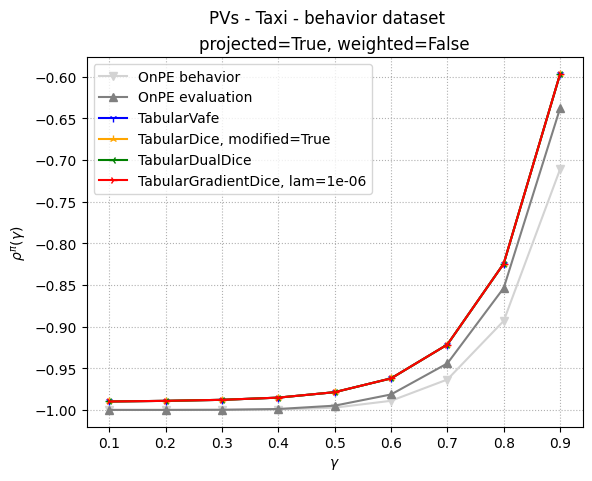

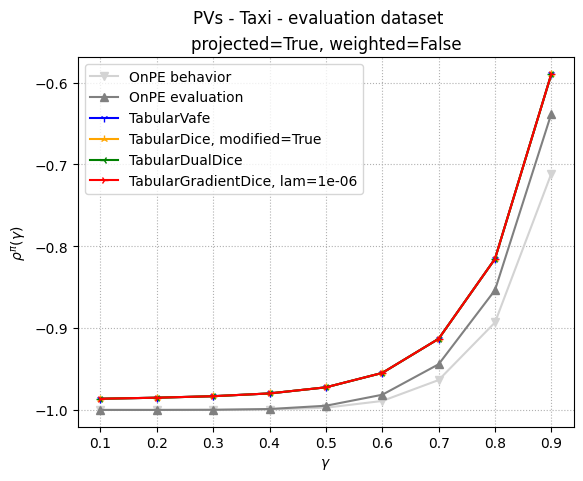

# ---------------------------------------------------------------- #


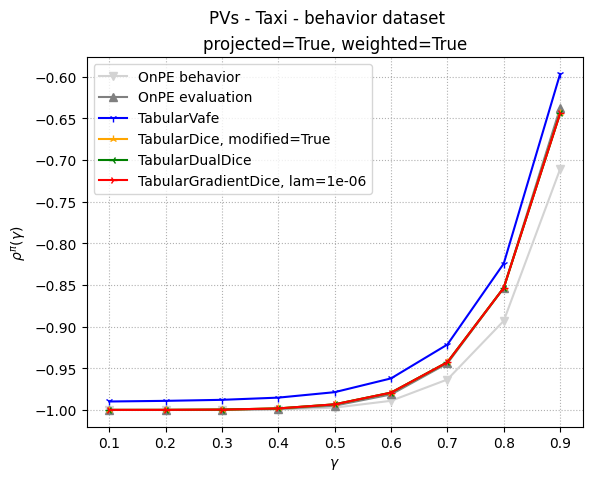

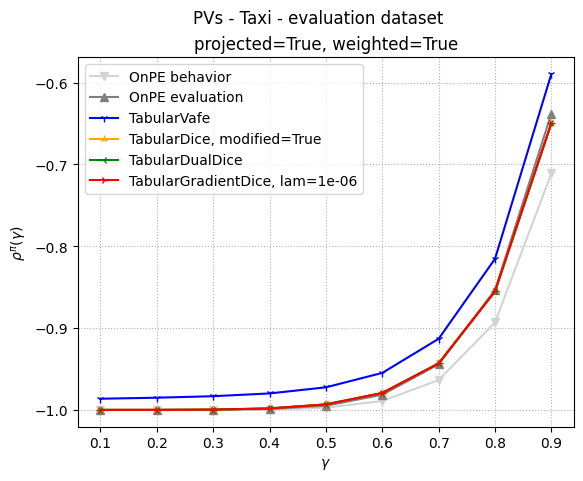

In [173]:
for k in K:
    plot_pvs_wrapped_1(k, weighted=False, errors=False)

print("#", "-"*64, "#")

for k in K:
    plot_pvs_wrapped_1(k, weighted=True, errors=False)

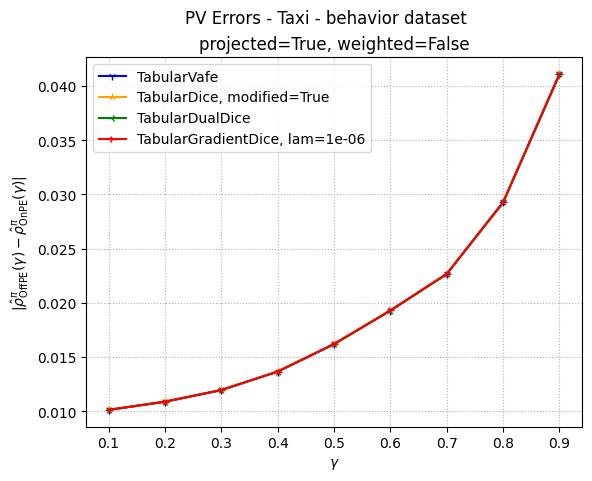

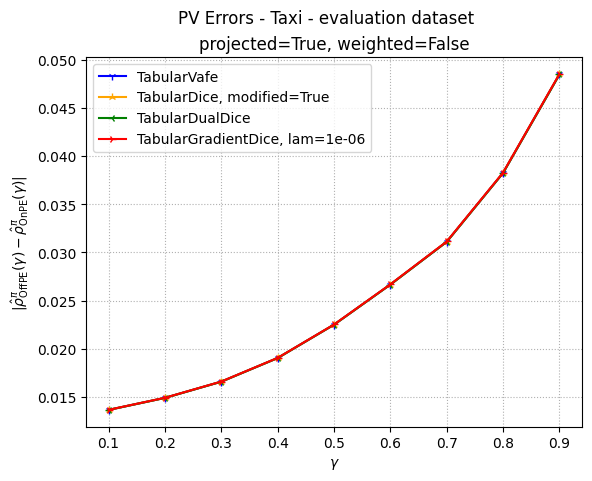

# ---------------------------------------------------------------- #


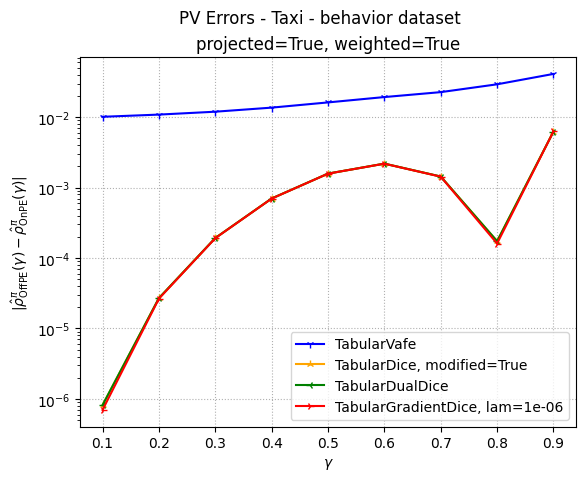

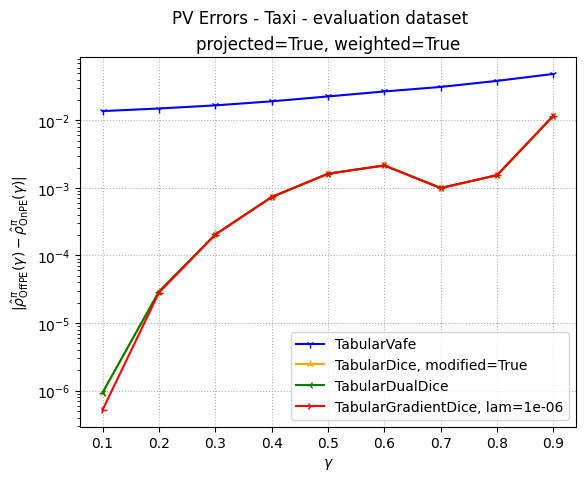

In [174]:
for k in K:
    plot_pvs_wrapped_1(k, weighted=False, errors=True)

print("#", "-"*64, "#")

for k in K:
    plot_pvs_wrapped_1(k, weighted=True, errors=True)

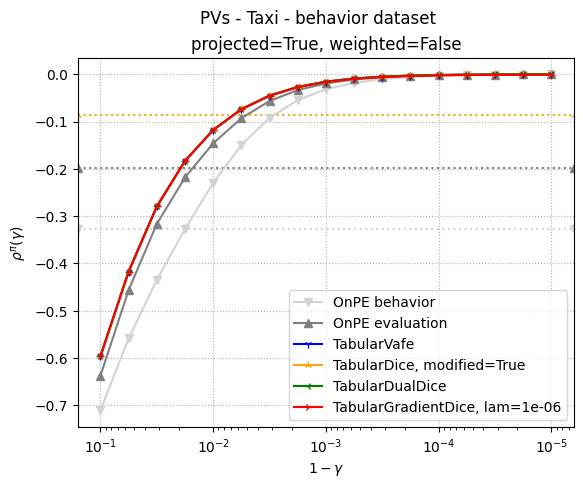

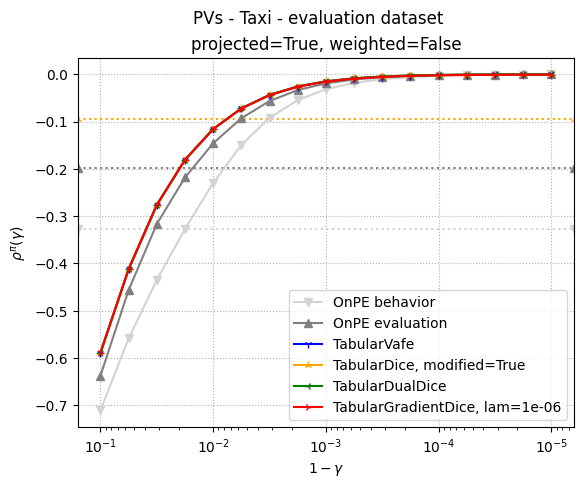

# ---------------------------------------------------------------- #


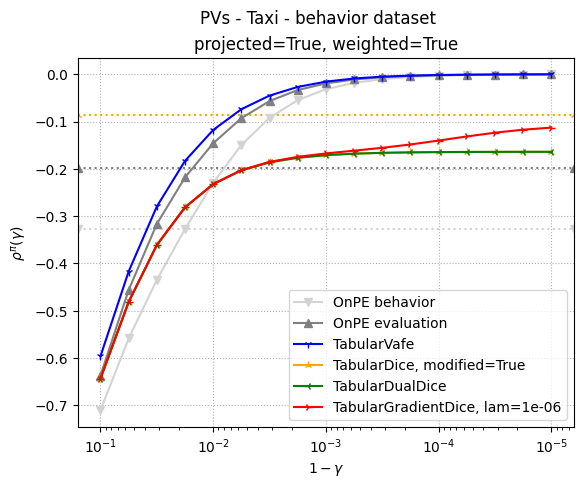

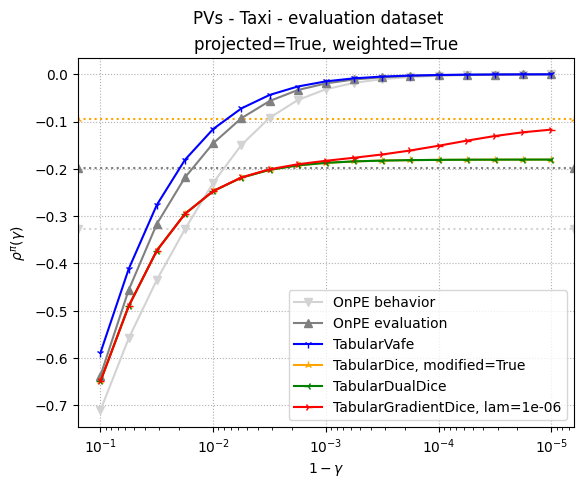

In [175]:
for k in K:
    plot_pvs_wrapped_2(k, weighted=False, errors=False)

print("#", "-"*64, "#")

for k in K:
    plot_pvs_wrapped_2(k, weighted=True, errors=False)

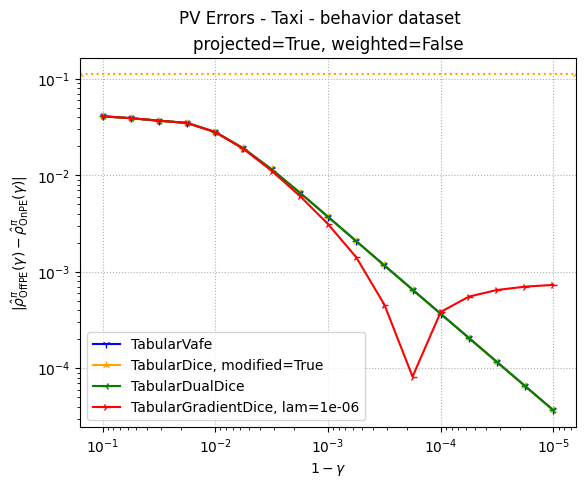

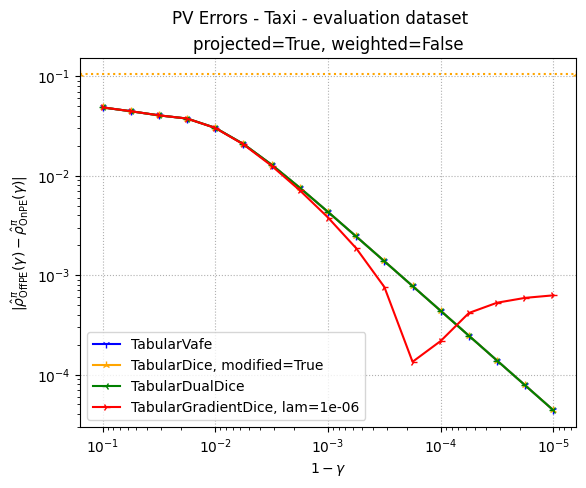

# ---------------------------------------------------------------- #


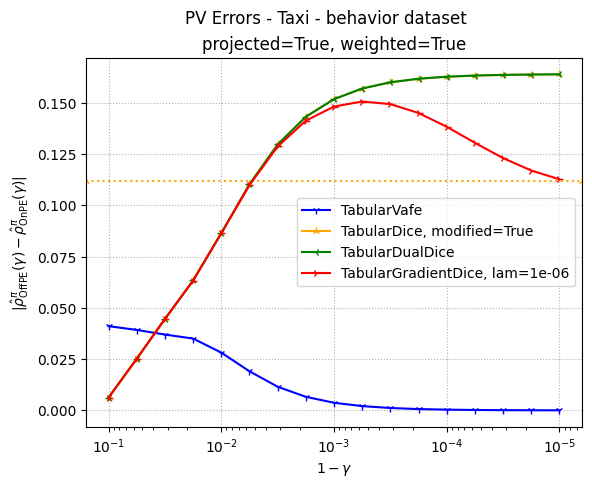

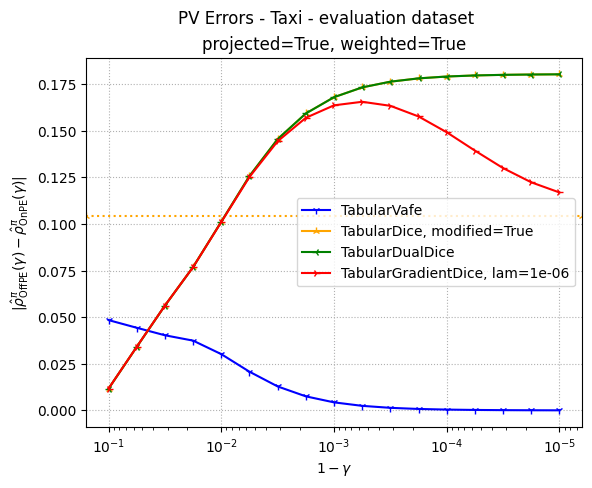

In [176]:
for k in K:
    plot_pvs_wrapped_2(k, weighted=False, errors=True)

print("#", "-"*64, "#")

for k in K:
    plot_pvs_wrapped_2(k, weighted=True, errors=True)

# Test

## `env`

In [78]:
O = []
A = []
R = []

ts = env.reset()
O.append( int(ts.observation) )


for _ in range(50):
    ps = target_policy.action(ts)
    A.append(int(ps.action))
    ts = env.step(ps.action)

    R.append( float(ts.reward) )
    O.append( int(ts.observation) )

O.pop()

pd.DataFrame({ "O": O, "A": A, "R": R, })

/Users/richardweiss/Documents/.venvs/dice_rl_TU_Vienna/lib/python3.11/site-packages/gym/utils/seeding.py:47: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(
/Users/richardweiss/Documents/.venvs/dice_rl_TU_Vienna/lib/python3.11/site-packages/tensorflow/python/framework/ops.py:304: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self._numpy())
/Users/richardweiss/Documents/.venvs/dice_rl_TU_Vienna/lib/python3.11/site-packages/gym/utils/seeding.py:27: DeprecationWarning: WARN: Function `rng.rand(*size)` is marked as deprecated and will be removed in the future. Please use `Generator.random(size)` instead.
  deprecation(


,O,A,R
0,399,3,-1.0
1,319,0,-1.0
2,699,3,-1.0
3,614,3,-1.0
4,524,3,-1.0
5,449,3,-1.0
6,449,2,-1.0
7,49,4,-1.0
8,47,0,-1.0
9,407,0,-1.0


In [113]:
env_gymnasium = gymnasium.make("Taxi-v3")

def get_act_target_policy(obs):
    ts = TimeStep(
        step_type=1,
        reward=0,
        discount=1,
        observation=obs,
    )

    return int( target_policy.action(ts).action )


test_env(
    env=env_gymnasium,
    get_act=get_act_target_policy,
    num_trajectory=1,
    max_trajectory_length=100,
    verbosity=2,
)

84, 3 -1
64, 5 -10
64, 3 -1
44, 2 -1
64, 2 -1
84, 3 -1
64, 1 -1
64, 5 -10
64, 5 -10
64, 1 -1
64, 4 -10
64, 5 -10
64, 4 -10
64, 3 -1
44, 5 -10
44, 1 -1
44, 4 -10
44, 4 -10
44, 4 -10
44, 3 -1
44, 2 -1
64, 2 -1
84, 4 -1
96, 5 -1
84, 4 -1
96, 0 -1
196, 0 -1
296, 1 -1
196, 4 -10
196, 0 -1
296, 1 -1
196, 4 -10
196, 2 -1
196, 3 -1
176, 4 -10
176, 4 -10
176, 4 -10
176, 0 -1
276, 3 -1
256, 4 -10
256, 2 -1
276, 1 -1
176, 1 -1
76, 1 -1
76, 1 -1
76, 1 -1
76, 1 -1
76, 1 -1
76, 2 -1
96, 1 -1
96, 1 -1
96, 0 -1
196, 2 -1
196, 1 -1
96, 5 -1
84, 5 -10
84, 3 -1
64, 1 -1
64, 5 -10
64, 2 -1
84, 0 -1
184, 5 -10
184, 3 -1
164, 5 -10
164, 1 -1
64, 3 -1
44, 2 -1
64, 4 -10
64, 4 -10
64, 2 -1
84, 4 -1
96, 3 -1
76, 1 -1
76, 1 -1
76, 1 -1
76, 1 -1
76, 1 -1
76, 1 -1
76, 1 -1
76, 1 -1
76, 1 -1
76, 1 -1
76, 1 -1
76, 2 -1
96, 3 -1
76, 1 -1
76, 1 -1
76, 1 -1
76, 1 -1
76, 1 -1
76, 1 -1
76, 2 -1
96, 3 -1
76, 1 -1
76, 1 -1
76, 1 -1
76, 1 -1
76, 1 -1
76, 1 -1
76, 2 -1
96, truncated



{'distinct_absolute': (12.0, 0.0),
 'distinct_relative': (0.1188118811881188, 0.0),
 'all': (101.0, 0.0)}

## Estimators

(s, a) visited:
{'absolute': 7789, 'relative': 0.6490833333333333}
(s, a) not visited:
{'absolute': 4211, 'relative': 0.35091666666666665}

# dD_bar[i] == 0, but P_bar[i, :] != 0: 0
# dD_bar[i] == 0, but P_bar[:, i] != 0: 15288
# dD_bar[i], but d0_bar[i] != 0: 25

# ---------------------------------------------------------------- # 



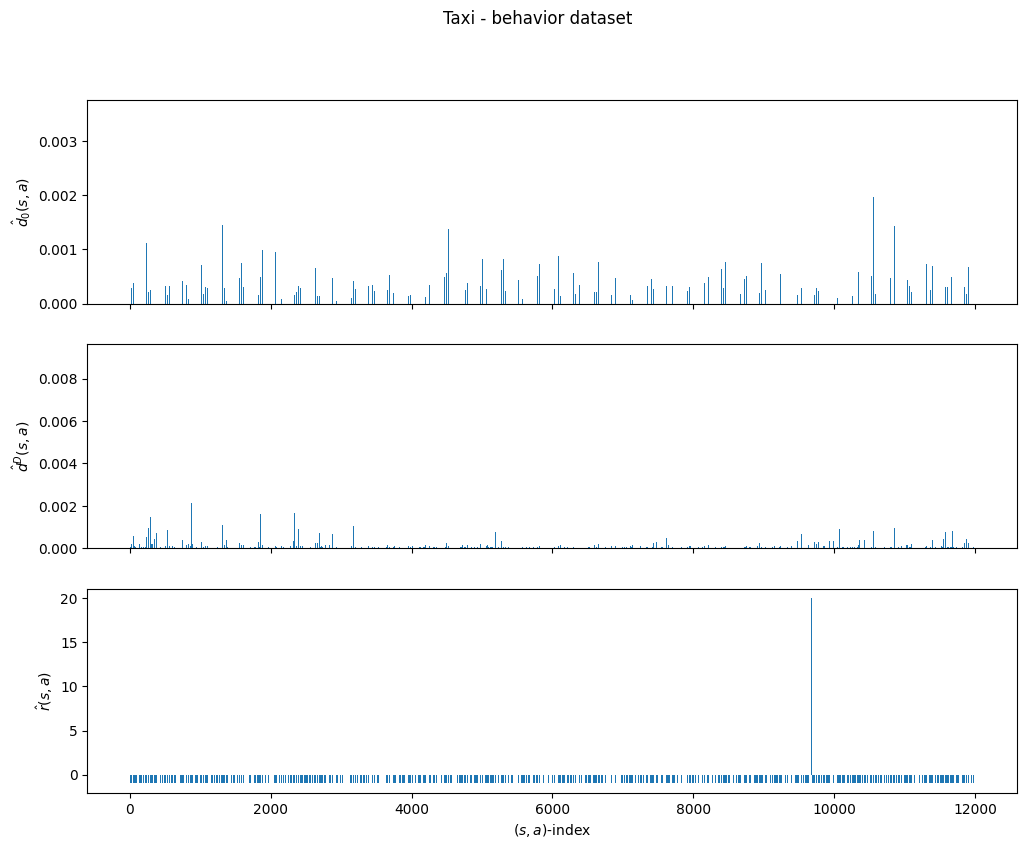

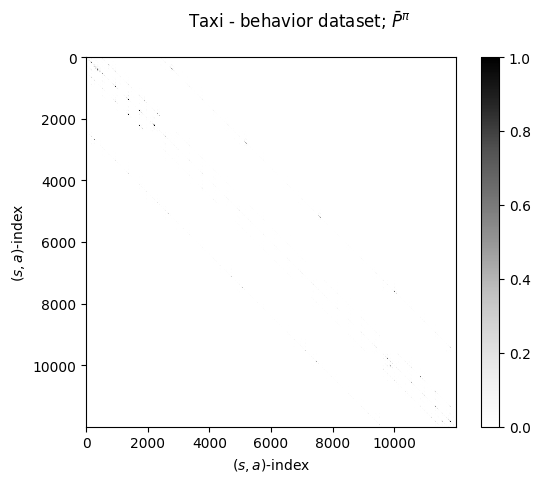

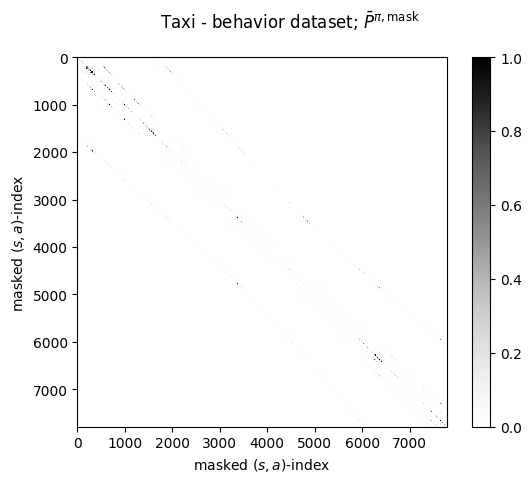

# ---------------------------------------------------------------- # 



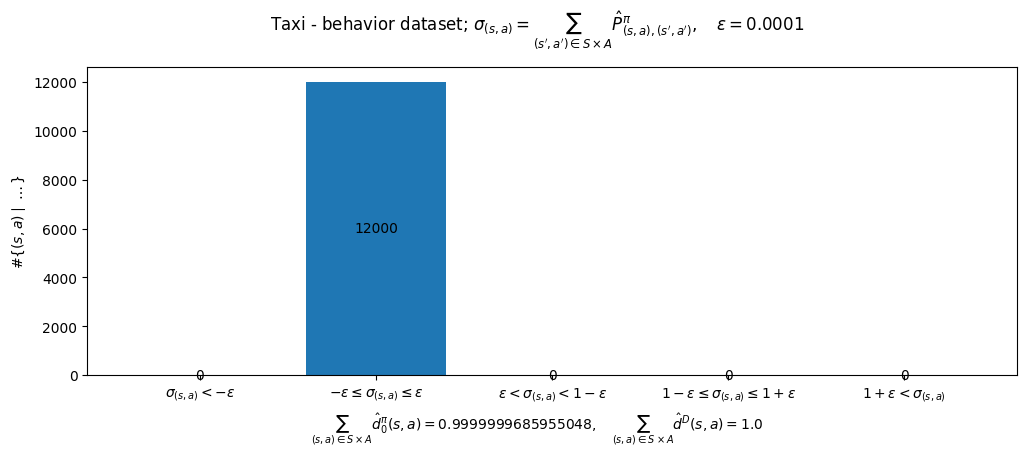

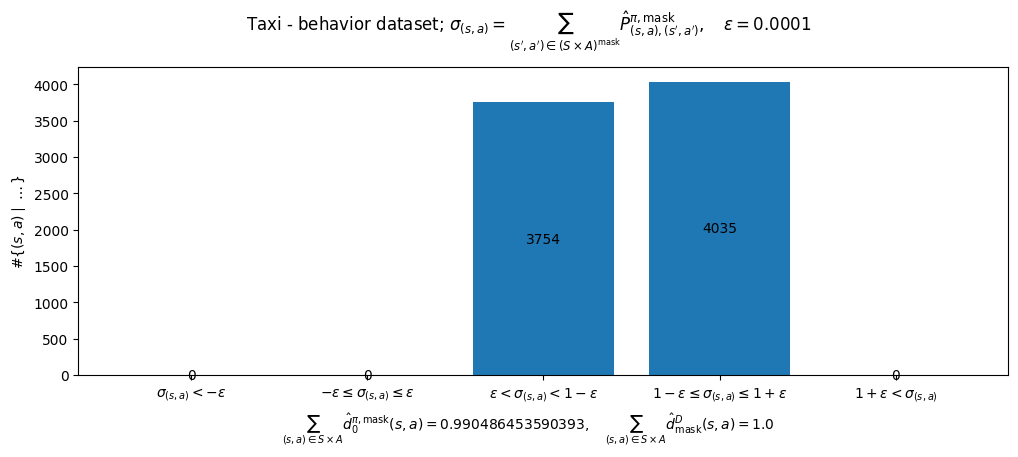

# ---------------------------------------------------------------- # 



In [186]:
k = "b"

test_aux_estimates(
    aux_estimates=aux_estimates[k],
    title_prefix=f"Taxi - {names[k]} dataset",
    save_dir=os.path.join(save_dir_images, "aux_estimates"),
)

(s, a) visited:
{'absolute': 7373, 'relative': 0.6144166666666667}
(s, a) not visited:
{'absolute': 4627, 'relative': 0.38558333333333333}

# dD_bar[i] == 0, but P_bar[i, :] != 0: 0
# dD_bar[i] == 0, but P_bar[:, i] != 0: 17067
# dD_bar[i], but d0_bar[i] != 0: 37

# ---------------------------------------------------------------- # 



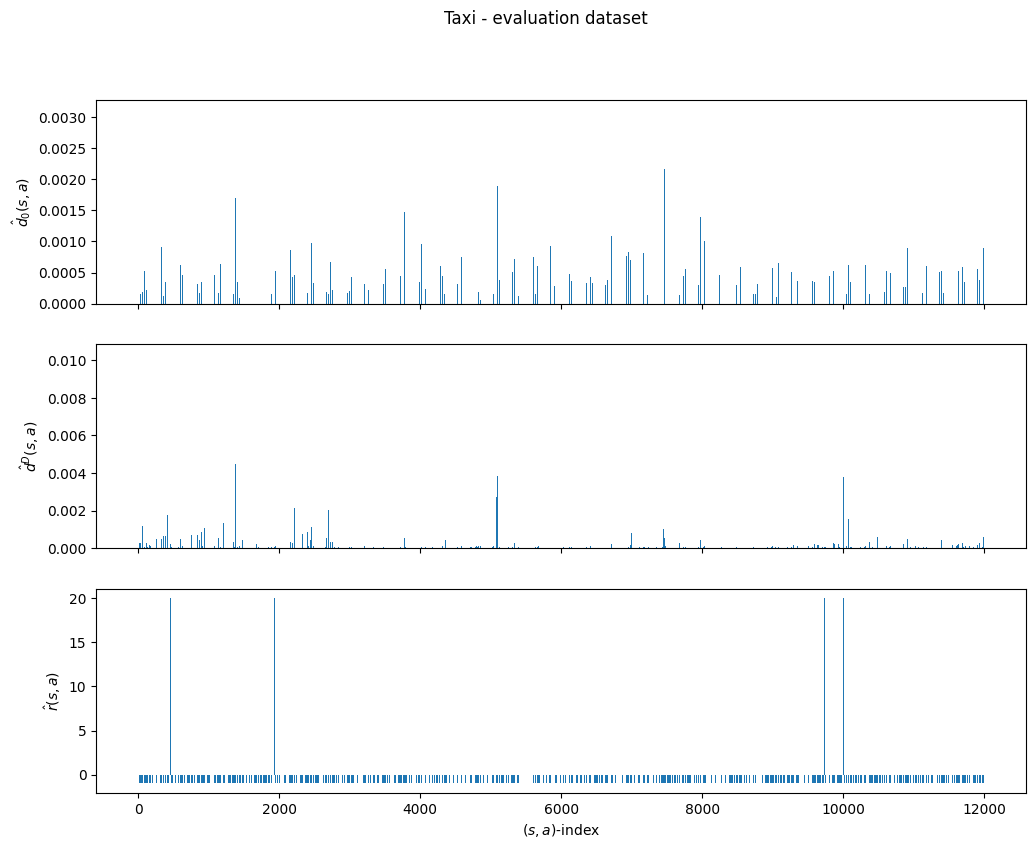

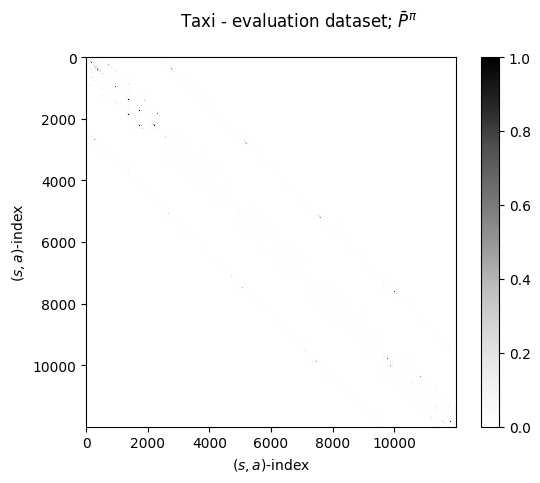

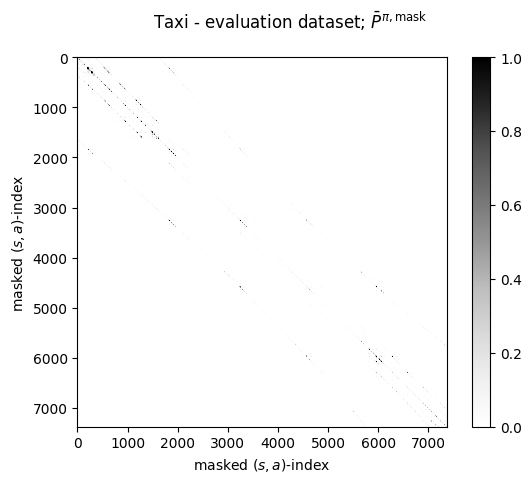

# ---------------------------------------------------------------- # 



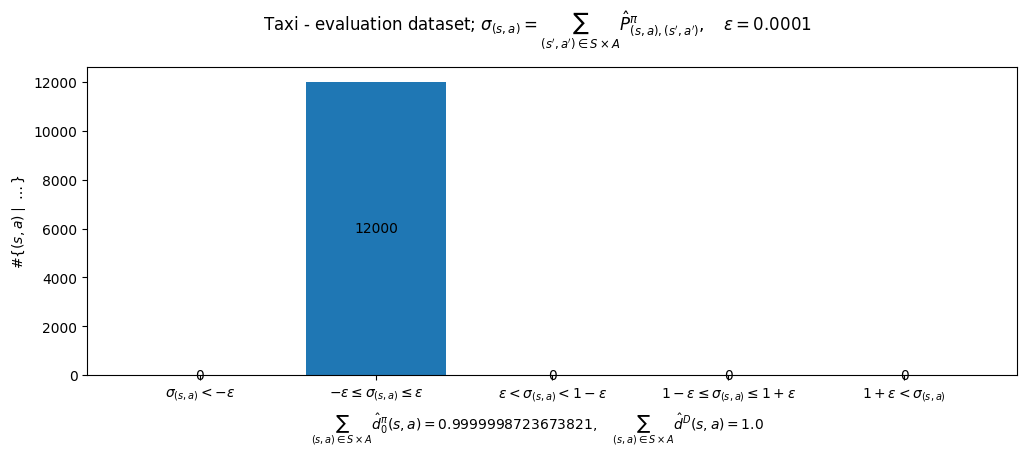

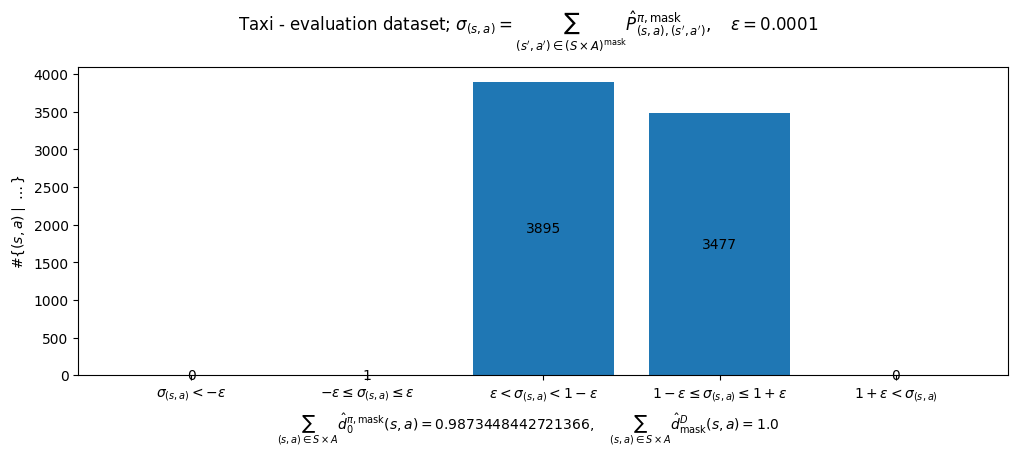

# ---------------------------------------------------------------- # 



In [187]:
k = "e"

test_aux_estimates(
    aux_estimates=aux_estimates[k],
    title_prefix=f"Taxi - {names[k]} dataset",
    save_dir=os.path.join(save_dir_images, "aux_estimates"),
)

pv=-0.6440832018852234
np.dot(sdc_hat, dD_hat)=0.9265472966441386



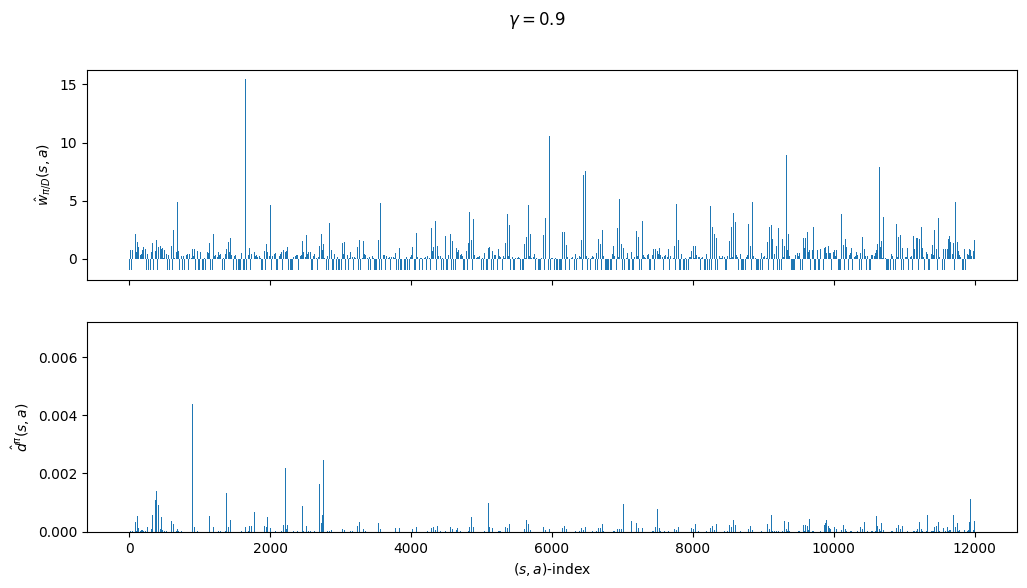

In [184]:
k = "b"

test_estimator(
    estimator_DICE=estimators_DICE[k][0],
    gamma=0.9,
    projected=projected, weighted=True,
    modified=modified,
)

pv=-0.6495311856269836
np.dot(sdc_hat, dD_hat)=0.9074036191783112



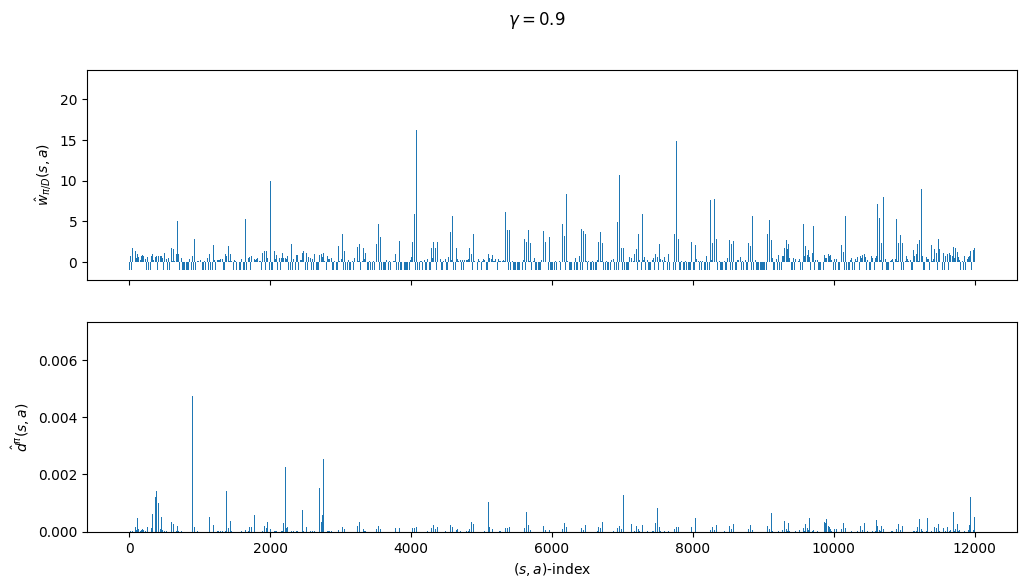

In [185]:
k = "e"

test_estimator(
    estimator_DICE=estimators_DICE[k][0],
    gamma=0.9,
    projected=projected, weighted=True,
    modified=modified,
)

## `dice_rl`

In [30]:
load_dir = os.path.join("data", "dice_rl", "taxi")

load_dir_dataset = os.path.join(load_dir, "datasets")
load_dir_policy = os.path.join(load_dir, "policies")

run_tabular_dual_dice(
    env_name=env_name, tabular_obs=tabular_obs, alpha=0.0, seed=seed, num_trajectory=num_trajectory, max_trajectory_length=max_trajectory_length,
    gamma=0.9, solve_for_state_action_ratio=True,
    load_dir_dataset=load_dir_dataset, load_dir_policy=load_dir_policy, save_dir=None,
)

Loading dataset.
data/dice_rl/taxi/datasets/taxi_tabularTrue_alpha0.0_seed0_numtraj1000_maxtraj100/dataset-ctr.pkl
num loaded steps tf.Tensor(100000, shape=(), dtype=int64)
num loaded total steps tf.Tensor(101000, shape=(), dtype=int64)
num loaded episodes tf.Tensor(1000, shape=(), dtype=int64)
num loaded total episodes tf.Tensor(1000, shape=(), dtype=int64)


/Users/richardweiss/Documents/.venvs/dice_rl_TU_Vienna/lib/python3.11/site-packages/gym/utils/seeding.py:47: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(


estimated per step avg tf.Tensor(-0.6556416, shape=(), dtype=float32)
Done!
